<div style="display: block; left-margin: 0px; right-margin: 0px;"><img src="FIFA_series_logo.png" alt="Drawing" style="width: 200px;"/></div>

# FIFA voetbal casus

### Voorwoord  <a id='Voorwoord'></a>
In deze studie zullen Wail Abou, Bart de Vries en Youssef Boulfiham een aantal onderwerpen over FIFA onderzoeken. Voor dit onderzoek zullen we te werk gaan met datasets over voetbalspelers en voetbalwedstrijden uit het seizoen 2019-2020 Met behulp van statistische analyse zullen we trachten om tot nieuwe ontdekkingen en conclusies te komen.

### Inhoudsopgave <a id='Inhoudsopgave'></a>
- [Voorwoord](#Voorwoord)
- [Inhoudsopgave](#Inhoudsopgave)
- [Datasets](#Datasets)
- [Onze verwachtingen](#Onze_verwachtingen)
- [Onderzoeken](#Onderzoeken)
    - [libraries importeren](#libraries_importeren)
    - [spelers-dataset importeren](#spelers-dataset)
    - [wedstrijden-dataset importeren](#wedstrijden-dataset)
    - [Data cleaning](#Data_cleaning)
    - [Data exploratie](#Data_exploratie)
    - [Spider plot van Spelers](#Spider_plot)
    - [Onderzoeksvragen](#Onderzoeksvragen)
        - [onderzoeksvraag 1](#1)
        - [onderzoeksvraag 2](#2)
        - [onderzoeksvraag 3](#3)

### Datasets <a id='Datasets'></a>
- FIFA-spelerseigenschappen van seizoen 2019-2020
- FIFA-wedstrijd uitslagen van seizoen 2019-2020

### Onze verwachtingen <a id='Onze_verwachtingen'></a>
- Nieuwe inzichtingen over de prijs en kwaliteit verhoudingen van de spelers.
- Voorspellingen van wedstrijden en slagingspercentage van deze wedstrijden.
- Invloed van bepaalde specifieke factoren op de prijs bepaling van spelers.

## Onderzoeken <a id='Onderzoeken'></a>

###### libraries importeren <a id='libraries_importeren'></a>

In [325]:
# libraries  importeren.
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import csv, glob, os
from ipywidgets import interact, widgets, interactive
from sklearn.linear_model import LinearRegression

# modules voor warning supressions.
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

###### Spelers-dataset importeren <a id='Spelers-dataset'></a>

begeleidend schrijven.

In [326]:
# .csv bestand uitlezen en omzetten naar pandas array van 18207x89
players = pd.read_csv('csv/fifa19.csv')
# players

###### wedstrijden-dataset importeren <a id='wedstrijden-dataset'></a>

begeleidend schrijven.

In [327]:
# Alle files via de path krijgen
path = r'wedstrijden'     
all_files = glob.glob(os.path.join(path, "*.csv"))

# Alle files in een dataframe inlezen via een list comprehension
data_frames = (pd.read_csv(f, encoding='cp1252', sep=';') for f in all_files)
clubs = pd.concat(data_frames, ignore_index=True)

# Relevanten kollommen selecteren
clubs = clubs[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]]

# De date omzetten naar de date object van panda
clubs.Date = pd.to_datetime(clubs.Date)

# De entries droppen die onder 2019 vallen
clubs = clubs.drop(clubs[clubs.Date < pd.Timestamp(2019, 1, 1)].index)

# Nieuwe kollom maken met de winnende team
clubs["WinningTeam"] = np.where(clubs["FTHG"] >= clubs["FTAG"], clubs["HomeTeam"], clubs["AwayTeam"])

# clubs

In [328]:
# lijst van alle onderdelen van de dataset
# print("kolommen:\n",players.columns)

### Data cleaning <a id='Data_cleaning'></a>

Data types controleren  
Bepaalde data types (height weight en value) omzetten naar float.

In [329]:
# data types van alle onderdelen.
players.dtypes

Unnamed: 0          int64
ID                  int64
Name               object
Age                 int64
Photo              object
                   ...   
GKHandling        float64
GKKicking         float64
GKPositioning     float64
GKReflexes        float64
Release Clause     object
Length: 89, dtype: object

Controleren of lege kolommen in de dataset bevind.   
het grootste deel van alle waardes zijn er.
bij de meeste mis onder 0,5% dus dit zal relatief schadeloos zijn.

In [330]:
#check voor lege waardes.
print(pd.isnull(players).sum())

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64


In [331]:
# We halen de lbs aan het einde weg en zetten we het om in een float
players['Weight'] = players['Weight'].str[:-3].astype(float)

# We halen de ' weg en vervangen het met . en vervolgens zetten we het om in een float
players['Height'] = players['Height'].str.replace("'", ".").astype(float)

# We halen de € en . weg, vervolgens vervangen we M met 6 nullen en K met 3 nullen en zetten het om in een int
players['Value'] = players['Value'].str.replace('€', '').str.replace('.', '')
players['Value'] = players['Value'].str.replace('M', '000000')
players['Value'] = players['Value'].str.replace('K', '000').astype(int)

# Laatste check om te zien of alles nu wel correct is
print(players[['Weight', 'Height', 'Value']].dtypes)

Weight    float64
Height    float64
Value       int32
dtype: object


We kunnen nu hierboven zien dat ze nu wel de juiste waarde hebben.

### Data exploratie <a id='Data_exploratie'></a>

Laten we kijken hoe een frequentieplot er uit ziet met betrekking tot de overall waarde. 

[Text(0, 0.5, 'frequentie'),
 Text(0.5, 0, 'Overall'),
 Text(0.5, 1.0, 'Overall x frequentie')]

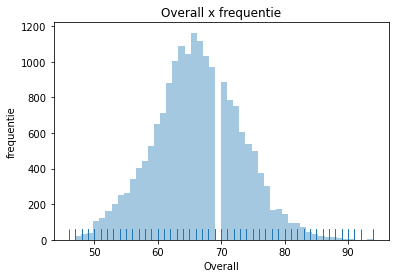

In [332]:
sns.distplot(players['Overall'], kde=False, rug=True).set(title='Overall x frequentie', xlabel='Overall', ylabel='frequentie')

Het geen wat gelijk opvalt is dat er een kolom leeg is namelijk die van 69.   
Dit komt niet door de data maar door de manier waarop we plotten, laten we een kijkje nemen naar de juiste aanpak.

[Text(0, 0.5, 'frequentie'),
 Text(0.5, 0, 'Overall'),
 Text(0.5, 1.0, 'Overall x frequentie')]

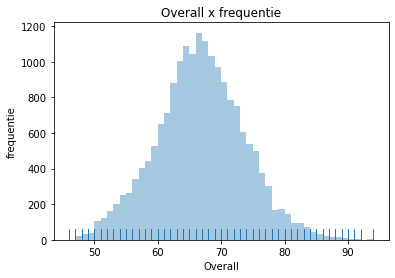

In [357]:
bin_amount = len(players['Overall'].unique())
sns.distplot(players['Overall'], kde=False, rug=True, bins=bin_amount).set(
    title='Overall x frequentie', xlabel='Overall', ylabel='frequentie')

Hier zien we de juiste weergave van de frequentieplot, het probleem was dat seaborn zelf probeerde te gokken hoeveel waardes er in de players['Overall'] zit.  
Maar wat seaborn niet weet is dat we een apparte staaf willen hebben voor elke unieke waarde, dus dat geven we mee als een paramater.  
Vervolgens zien we een plot zoals we die zouden verwachten, we kunnen dit vergelijken met dataset en dan zien we dat het klopt.

In [355]:
players['Overall'].value_counts().head().to_frame()

,Overall
66,1163
67,1118
64,1091
65,1045
68,1035


Zoals we hier kunnen zien zal de piek rond de 66 zitten en dit klopt ook met onze grafiek.  

###### Spider plot van Spelers <a id='spider_plot'></a>

In [335]:
# Alleen relevante data selecteren en de beste en slechtste speler
player_skills = ['Name', 'Agility', 'BallControl', 'Dribbling', 'Finishing','Stamina']

# Alle spelers met de releveante data ophalen
all_players = players[player_skills]
all_players = all_players.set_index('Name')

# Een lijst met namen van de 5 beste en 5 slechtse spelers
all_names = list(all_players.head().index.values) + list(all_players.tail().index.values)

# 2 Dropdown list widgets om een speler te kunnen selecteren
player1_widget = widgets.Dropdown(options = all_names, value = all_names[0], description='Player 1:')
player2_widget = widgets.Dropdown(options = all_names, value = all_names[-1], description='Player 2:')

# Functie om gegeven 2 namen de spelers in een spiderplot te kunnen zetten
def spiderplot_players(p1, p2):
    # Groote van de plot bepalen
    plt.figure(figsize=(20, 20))
    
    # De kollomen van de spelers ophalen
    comparison_players = all_players.loc[[p1, p2]] 

    for name, skills in comparison_players.iterrows():
        categories = skills.index.values

        # Alle punten om te tekenen
        points = list(skills.values)
        points += points[:1]

        # Alle hoeken berekenen
        angles = [side / float(len(categories)) * 2 * np.pi for side in range(len(categories))]
        angles += angles[:1]

        # De spider plot aanmaken
        sp = plt.subplot(3, 3, 1, polar=True)

        # De categorieen weergeven
        plt.xticks(angles, categories)

        # De markers weergeven
        plt.yticks([25, 50, 75], ["25", "50", "75"], color="grey")
        plt.ylim(0,100)

        # Alles plotten en opvullen
        sp.plot(angles, points)
        sp.fill(angles, points, alpha=0.1)

    # De titel plotten
    names = comparison_players.index.values
    plt.title(f'{names[0]} vs {names[1]}', y=1.1)
    
interactive(spiderplot_players, p1=player1_widget, p2=player2_widget)

interactive(children=(Dropdown(description='Player 1:', options=('L. Messi', 'Cristiano Ronaldo', 'Neymar Jr',…

_Met behulp van de bovenstaande grafiek stellen we ons in staat om in een oogopslag de kernkwaliteiten van de spelers in te zien en te vergelijken._

### Doel: alle westrijden in een dataframe te krijgen met een extra kolom voor de resultaten.

_Nu hebben we een handige tabel met daarin alleen de relevante data voor ons._

### Onderzoeksvragen <a id='Onderzoeksvragen'></a>


###### 1 In hoeverre is de prijs van een speler te voorspellen aan de hand van zijn belangrijkste kenmerken? <a id='1'></a>
supervised
Wij zullen bij deze vraag linear regression gebruiken om te kijken in hoeverre een punt bij de lijn zit, dit laat ons weten of er daadwerkelijk een linear verband is tussen de prijs van een speler en zijn belangrijkste kenmerken.

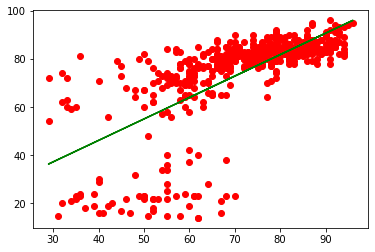

In [336]:
value_players = players[['Agility', 'BallControl']][0:500]

X = value_players.iloc[:, 0].values.reshape(-1, 1)
Y = value_players.iloc[:, 1].values.reshape(-1, 1) 

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X, Y, color='red')
plt.plot(X, Y_pred, color='green')
plt.show()

###### Onderzoeksvraag 2 <a id='2'></a>

__Kan je op basis van de gemiddelde waardes van een team voorspellen welke van de 2 teams zullen winnen?__


unsupervised
Bij deze vraag gaan we correlatie analyses uitvoeren en een externe dataset gebruiken om meer inzicht te vekrijgen, de externe dataset die we gaan gebruiken is de bovengenoemde "FIFA-wedstrijd uitslagen van seizoen 2019-2020".

###### Onderzoeksvraag 3 <a id='3'></a>
__Is er een verband tussen de gewicht, lengte, prijs, leeftijd en positie van een speler?__

unsupervised
Hierbij zullen wij clustering gaan gebruiken om mogelijke patronen te ontdekken.

laatste opdracht: https://canvas.hu.nl/courses/20299/assignments/93793

FIFA 2018

Een voetbalcommentator beweert dat de potentie van de huidige generatie Engelse spelers sterk verschilt van spelers uit de rest van de wereld.

Onderzoek met de dataset of de commentator gelijk heeft. Neem een steekproef van 100 Engelse spelers en beschouw als populatie alle niet-Engelse spelers in de data set. Kies als betrouwbaarheid 95%.